## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import gdown # Для загрузки данных с Google drive

Прочитаем наш файл с исходными данными:

In [2]:
!mkdir data # Создадим папку для датасета

In [3]:
gdown.download(id='1bL9Q7U5-Hki054FwcDzTmgpuf1LOv5Su', output='data/train.csv') # Скачаем датасет и поместим по адресу 'data/train.csv'

Downloading...
From (original): https://drive.google.com/uc?id=1bL9Q7U5-Hki054FwcDzTmgpuf1LOv5Su
From (redirected): https://drive.google.com/uc?id=1bL9Q7U5-Hki054FwcDzTmgpuf1LOv5Su&confirm=t&uuid=3e9536e5-ae0a-4d85-9cca-50b6bfe9f7b6
To: F:\Games\JetBrains\Projects\Project_2\для себя\data\train.csv
100%|██████████| 201M/201M [02:04<00:00, 1.60MB/s] 


'data/train.csv'

In [8]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [9]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [10]:
taxi_data['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Как видим, данные предоставлены за период с **2016-01-01** по **2016-06-30**.

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [11]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [8]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Как видим, пропущенных значений **нет**.

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [9]:
taxi_data['vendor_id'].nunique()

2

In [12]:
pd.options.display.float_format = '{:,.3f}'.format # Сделаем нормальное отображение цифр
taxi_data.describe()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,"1,458,644.000",1458644,"1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000"
mean,1.535,2016-04-01 10:10:24.940037120,1.665,-73.973,40.751,-73.973,40.752,959.492
min,1.000,2016-01-01 00:00:17,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,2016-02-17 16:46:04.249999872,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,2016-04-01 17:19:40,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2016-05-15 03:56:08.750000128,2.000,-73.967,40.768,-73.963,40.770,"1,075.000"
max,2.000,2016-06-30 23:59:39,9.000,-61.336,51.881,-61.336,43.921,"3,526,282.000"
std,0.499,NaN,1.314,0.071,0.033,0.071,0.036,"5,237.432"


а) В данных есть **2** уникальных таксопарка.

б) Максимальное количество пассажиров - **9**.

в) Средняя длительность поездки - **959** секунд, медианная - **662** секунды.

г) Минимальное время поездки - **1** секунда, максимальное - **3526282** секунд.


9 пассажиров в одном такси выглядит странновато. Неужели наши таксисты нарушают ПДД? Впрочем, 0 пассажиров мы тоже здесь встретим.

Минимальное и максимальное время поездки тоже вызывают вопросы, будем разбираться с этим дальше.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [13]:
taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.date
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.weekday

In [14]:
taxi_data['pickup_day_of_week'].value_counts()

pickup_day_of_week
4    223533
5    220868
3    218574
2    210136
1    202749
6    195366
0    187418
Name: count, dtype: int64

In [15]:
taxi_data['id'].count() / taxi_data['pickup_date'].nunique()

8014.527472527472

а) В субботу было совершено **220868 поездок**.

б) В среднем в день совершается **8015 поездок**.

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [14]:
gdown.download(id='1dgclPFmCHatMIGQig9UHrpbYRi2v-Ne-', output='data/holiday_data.csv') # Скачаем датасет праздников и поместим по адресу 'data/holiday_data.csv'

Downloading...
From: https://drive.google.com/uc?id=1dgclPFmCHatMIGQig9UHrpbYRi2v-Ne-
To: F:\Games\JetBrains\Projects\Project_2\для себя\data\holiday_data.csv
100%|██████████| 508/508 [00:00<00:00, 507kB/s]


'data/holiday_data.csv'

In [16]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

In [17]:
# Преобразуем столбец 'pickup_date' таблицы taxi_data в формат datetime
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'], format='%Y-%m-%d')

# Преобразуем столбец 'date' таблицы holiday_data в формат datetime
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%Y-%m-%d')

# Смержим в новый датафрейм таблицы taxi_data и holiday_data на основании даты
taxi_data = taxi_data.merge(holiday_data['date'], how='left', left_on='pickup_date', right_on='date')

# Добавим новый столбец 'pickup_holiday', в котором будет 1, если в столбце 'date' есть дата, иначе 0.
taxi_data['pickup_holiday'] = taxi_data['date'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Удалим теперь ненужный нам столбец 'date'
taxi_data.drop('date', axis= 1 , inplace= True)

In [18]:
taxi_data.query('pickup_holiday == 1').describe()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
count,"51,122.000",51122,"51,122.000","51,122.000","51,122.000","51,122.000","51,122.000","51,122.000",51122,"51,122.000","51,122.000","51,122.000"
mean,1.545,2016-03-16 22:28:50.665447424,1.704,-73.972,40.750,-73.972,40.751,867.610,2016-03-16 09:01:24.926254848,12.956,3.006,1.000
min,1.000,2016-01-01 00:00:17,0.000,-75.241,40.100,-75.570,36.398,2.000,2016-01-01 00:00:00,0.000,0.000,1.000
25%,1.000,2016-01-18 19:34:06.750000128,1.000,-73.992,40.736,-73.992,40.734,356.000,2016-01-18 00:00:00,9.000,0.000,1.000
50%,2.000,2016-02-15 11:05:11,1.000,-73.982,40.753,-73.980,40.754,585.000,2016-02-15 00:00:00,14.000,4.000,1.000
75%,2.000,2016-05-08 22:57:53.249999872,2.000,-73.967,40.768,-73.961,40.770,964.000,2016-05-08 00:00:00,18.000,6.000,1.000
max,2.000,2016-06-19 23:59:56,8.000,-73.428,41.431,-70.346,41.201,"86,392.000",2016-06-19 00:00:00,23.000,6.000,1.000
std,0.498,NaN,1.324,0.042,0.030,0.043,0.039,"3,123.483",NaN,6.708,2.540,0.000


Медианная длительность поездки на такси в праздничные дни составляет **585 секунд**.

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [18]:
gdown.download(id='1B8hMmhhBx7UOtd-dF1dmY-ZXgNe2_ixk', output='data/osrm_data_train.csv') # Скачаем датасет OSRM и поместим по адресу 'data/osrm_data_train.csv'

Downloading...
From (original): https://drive.google.com/uc?id=1B8hMmhhBx7UOtd-dF1dmY-ZXgNe2_ixk
From (redirected): https://drive.google.com/uc?id=1B8hMmhhBx7UOtd-dF1dmY-ZXgNe2_ixk&confirm=t&uuid=3eaa2bca-2e62-4b4b-9da8-7d3fa484e7ad
To: F:\Games\JetBrains\Projects\Project_2\для себя\data\osrm_data_train.csv
100%|██████████| 736M/736M [05:58<00:00, 2.05MB/s] 


'data/osrm_data_train.csv'

In [19]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [20]:
taxi_data = taxi_data.merge(osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], how='left', left_on='id', right_on='id')

In [21]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [22]:
# Посмотрим, сколько строк имеют пропуски в столбцах с информацией из OSRM API
taxi_data.query('total_distance.isna() or total_travel_time.isna() or number_of_steps.isna()').shape[0]

1

а) Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM, равна **372 секунд**.

б) В столбцах с информацией из OSRM API после объединения таблиц содержится **1 пропуск**.

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [23]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [24]:
def add_geographical_features(target: pd.DataFrame):
  df = target.copy()
  df['haversine_distance'] = get_haversine_distance(target['pickup_latitude'], target['pickup_longitude'], target['dropoff_latitude'], target['dropoff_longitude'])
  df['direction'] = get_angle_direction(target['pickup_latitude'], target['pickup_longitude'], target['dropoff_latitude'], target['dropoff_longitude'])
  return df

Применим функцию к датасету:

In [25]:
taxi_data = add_geographical_features(taxi_data)

In [26]:
taxi_data.describe()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
count,"1,458,644.000",1458644,"1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000",1458644,"1,458,644.000","1,458,644.000","1,458,644.000","1,458,643.000","1,458,643.000","1,458,643.000","1,458,644.000","1,458,644.000"
mean,1.535,2016-04-01 10:10:24.940037120,1.665,-73.973,40.751,-73.973,40.752,959.492,2016-03-31 20:03:56.715196160,13.606,3.050,0.035,"4,626.383",389.372,7.547,3.441,-15.669
min,1.000,2016-01-01 00:00:17,0.000,-121.933,34.360,-121.933,32.181,1.000,2016-01-01 00:00:00,0.000,0.000,0.000,0.000,0.000,2.000,0.000,-179.993
25%,1.000,2016-02-17 16:46:04.249999872,1.000,-73.992,40.737,-73.991,40.736,397.000,2016-02-17 00:00:00,9.000,1.000,0.000,"1,666.100",181.500,5.000,1.232,-125.274
50%,2.000,2016-04-01 17:19:40,1.000,-73.982,40.754,-73.980,40.755,662.000,2016-04-01 00:00:00,14.000,3.000,0.000,"2,755.100",289.500,6.000,2.094,8.200
75%,2.000,2016-05-15 03:56:08.750000128,2.000,-73.967,40.768,-73.963,40.770,"1,075.000",2016-05-15 00:00:00,19.000,5.000,0.000,"5,113.800",490.700,9.000,3.875,53.405
max,2.000,2016-06-30 23:59:39,9.000,-61.336,51.881,-61.336,43.921,"3,526,282.000",2016-06-30 00:00:00,23.000,6.000,1.000,"94,204.200","5,135.400",46.000,"1,240.909",180.000
std,0.499,NaN,1.314,0.071,0.033,0.071,0.036,"5,237.432",NaN,6.400,1.954,0.184,"5,303.878",314.468,4.433,4.297,104.491


 - Таким образом медианное расстояние Хаверсина поездок (в километрах) **равно 2.09**

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [27]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(coords)

def add_cluster_features(target: pd.DataFrame, model: cluster.KMeans):
  df = target.copy()
  df['geo_cluster'] = model.predict(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].to_numpy())
  return df

taxi_data = add_cluster_features(taxi_data, kmeans)

F:\Games\JetBrains\Projects\Project_2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "F:\Games\JetBrains\Projects\Project_2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Anton\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Anton\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Anton\AppData\Loc

In [28]:
taxi_data[['geo_cluster']].value_counts()

geo_cluster
1              592117
0              392108
6              340489
8               45518
4               40234
5               32799
7               15355
9                  18
3                   4
2                   2
Name: count, dtype: int64

 - Таким образом в наименьшем по размеру географическом кластере содержится **2 поездки**

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [29]:
gdown.download(id='152UC7VWgEdMr-5qAwTKMf66ja2_0IRMT', output='data/weather_data.csv') # Скачаем датасет с погодными условиями и поместим по адресу 'data/weather_data.csv'

Downloading...
From: https://drive.google.com/uc?id=152UC7VWgEdMr-5qAwTKMf66ja2_0IRMT
To: F:\Games\JetBrains\Projects\Project_2\для себя\data\weather_data.csv
100%|██████████| 842k/842k [00:00<00:00, 1.25MB/s]


'data/weather_data.csv'

In [29]:
weather_data = pd.read_csv('data/weather_data.csv')

In [30]:
# Выделим интересующие нас столбцы
needle_weather_data = weather_data[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']].copy()
# Приведем поля date и hour к типас даты/инта для последующего слияния таблиц
needle_weather_data['date'] = pd.to_datetime(needle_weather_data['date'], format='%Y-%m-%d')
needle_weather_data['hour'].astype(np.int32)
needle_weather_data

,temperature,visibility,wind speed,precip,events,date,hour
0,7.800,8.000,5.600,0.800,NaN,2015-12-31,2
1,7.200,12.900,7.400,0.300,NaN,2015-12-31,3
2,7.200,12.900,0.000,0.000,NaN,2015-12-31,4
3,7.200,14.500,7.400,0.000,NaN,2015-12-31,5
4,7.200,11.300,5.600,0.000,NaN,2015-12-31,6
...,...,...,...,...,...,...,...
8782,5.000,16.100,7.400,0.000,NaN,2017-01-01,21
8783,5.600,16.100,9.300,0.000,NaN,2017-01-01,22
8784,5.600,16.100,7.400,0.000,NaN,2017-01-01,23
8785,5.000,16.100,7.400,0.000,NaN,2017-01-02,0


Напишем функцию для слияния таблиц и применим к датасету:

In [31]:
def add_weather_features(target: pd.DataFrame, weather: pd.DataFrame):
  df = target.copy()
  df = df.merge(weather, how='left', left_on=['pickup_date',	'pickup_hour'], right_on=['date', 'hour'])
  df.drop(columns=['date', 'hour'], inplace=True)
  return df

taxi_data = add_weather_features(taxi_data, needle_weather_data)

Количество поездок в различных погодных условиях:

In [32]:
taxi_data.events.value_counts()

events
Rain    58300
Snow    13126
Fog         1
Name: count, dtype: int64

Доля пропусков в столбцах с погодными условиями:

In [33]:
weather_missing_values_count = taxi_data[['temperature', 'visibility', 'wind speed', 'precip', 'events']].isnull().sum()
total_observations = taxi_data.shape[0]
weather_missing_percentage = (weather_missing_values_count / total_observations) * 100
print(round(weather_missing_percentage, 2))

temperature    0.820
visibility     0.820
wind speed     0.820
precip         0.820
events        95.100
dtype: float64


а) Поездок было совершено в снежную погоду - **13126**

б) Процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями - **0.82**

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [34]:
def fill_null_weather_data(target: pd.DataFrame):
  df = target.copy()
  weather_cols = ['temperature', 'visibility', 'wind speed', 'precip', 'total_distance', 'total_travel_time', 'number_of_steps']

  for col in weather_cols:
    df[col] = df[col].fillna(df.groupby('pickup_date')[col].transform('median'))


  df['events'] = df['events'].fillna('None')

  return df

taxi_data = fill_null_weather_data(taxi_data)

In [35]:
taxi_data.describe()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,...,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip
count,"1,458,644.000",1458644,"1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000",1458644,"1,458,644.000",...,"1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000","1,458,644.000"
mean,1.535,2016-04-01 10:10:24.940037120,1.665,-73.973,40.751,-73.973,40.752,959.492,2016-03-31 20:03:56.715196160,13.606,...,"4,626.382",389.372,7.547,3.441,-15.669,2.353,11.092,14.747,8.940,0.068
min,1.000,2016-01-01 00:00:17,0.000,-121.933,34.360,-121.933,32.181,1.000,2016-01-01 00:00:00,0.000,...,0.000,0.000,2.000,0.000,-179.993,0.000,-18.300,0.400,0.000,0.000
25%,1.000,2016-02-17 16:46:04.249999872,1.000,-73.992,40.737,-73.991,40.736,397.000,2016-02-17 00:00:00,9.000,...,"1,666.100",181.500,5.000,1.232,-125.274,0.000,3.900,16.100,5.600,0.000
50%,2.000,2016-04-01 17:19:40,1.000,-73.982,40.754,-73.980,40.755,662.000,2016-04-01 00:00:00,14.000,...,"2,755.100",289.500,6.000,2.094,8.200,1.000,11.100,16.100,9.300,0.000
75%,2.000,2016-05-15 03:56:08.750000128,2.000,-73.967,40.768,-73.963,40.770,"1,075.000",2016-05-15 00:00:00,19.000,...,"5,113.800",490.700,9.000,3.875,53.405,6.000,18.300,16.100,13.000,0.000
max,2.000,2016-06-30 23:59:39,9.000,-61.336,51.881,-61.336,43.921,"3,526,282.000",2016-06-30 00:00:00,23.000,...,"94,204.200","5,135.400",46.000,"1,240.909",180.000,9.000,32.200,16.100,137.000,11.900
std,0.499,NaN,1.314,0.071,0.033,0.071,0.036,"5,237.432",NaN,6.400,...,"5,303.877",314.468,4.433,4.297,104.491,2.606,9.122,3.053,7.211,0.462


 - Медиана в столбце temperature после заполнения пропусков **равна 11.1**.


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


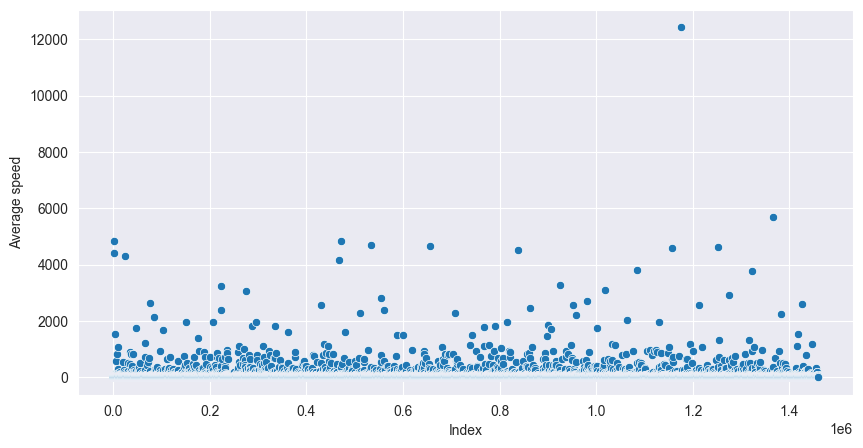

In [36]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [38]:
taxi_data[['total_distance', 'trip_duration']].describe()

,total_distance,trip_duration
count,"1,458,644.000","1,458,644.000"
mean,"4,626.382",959.492
std,"5,303.877","5,237.432"
min,0.000,1.000
25%,"1,666.100",397.000
50%,"2,755.100",662.000
75%,"5,113.800","1,075.000"
max,"94,204.200","3,526,282.000"


Проверим выброс по длительности, преобразовав столбец с секундами к часам, и отфильтровав:

In [37]:
trip_duration_in_hours = taxi_data['trip_duration'] / 60 / 60
taxi_data[trip_duration_in_hours > 24]['id'].count()

4

Воспользуемся формулой данной выше для вычисления выбросов по скорости:

In [38]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
taxi_data[avg_speed > 300]['id'].count()

407

In [39]:
# Зачищаем выбросы из данных
taxi_data.drop(taxi_data[trip_duration_in_hours > 24].index, inplace=True)
taxi_data.drop(taxi_data[avg_speed > 300].index, inplace=True)

C:\Users\Anton\AppData\Local\Temp\ipykernel_18764\2142169938.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxi_data.drop(taxi_data[avg_speed > 300].index, inplace=True)


 В итоге удалось найти:
 - выбросов по признаку длительности поездки - **4**
 - выбросов по признаку скорости - **407**

In [40]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458233 non-null  object        
 1   vendor_id           1458233 non-null  int64         
 2   pickup_datetime     1458233 non-null  datetime64[ns]
 3   dropoff_datetime    1458233 non-null  object        
 4   passenger_count     1458233 non-null  int64         
 5   pickup_longitude    1458233 non-null  float64       
 6   pickup_latitude     1458233 non-null  float64       
 7   dropoff_longitude   1458233 non-null  float64       
 8   dropoff_latitude    1458233 non-null  float64       
 9   store_and_fwd_flag  1458233 non-null  object        
 10  trip_duration       1458233 non-null  int64         
 11  pickup_date         1458233 non-null  datetime64[ns]
 12  pickup_hour         1458233 non-null  int32         
 13  pickup_day_of_wee

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [41]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

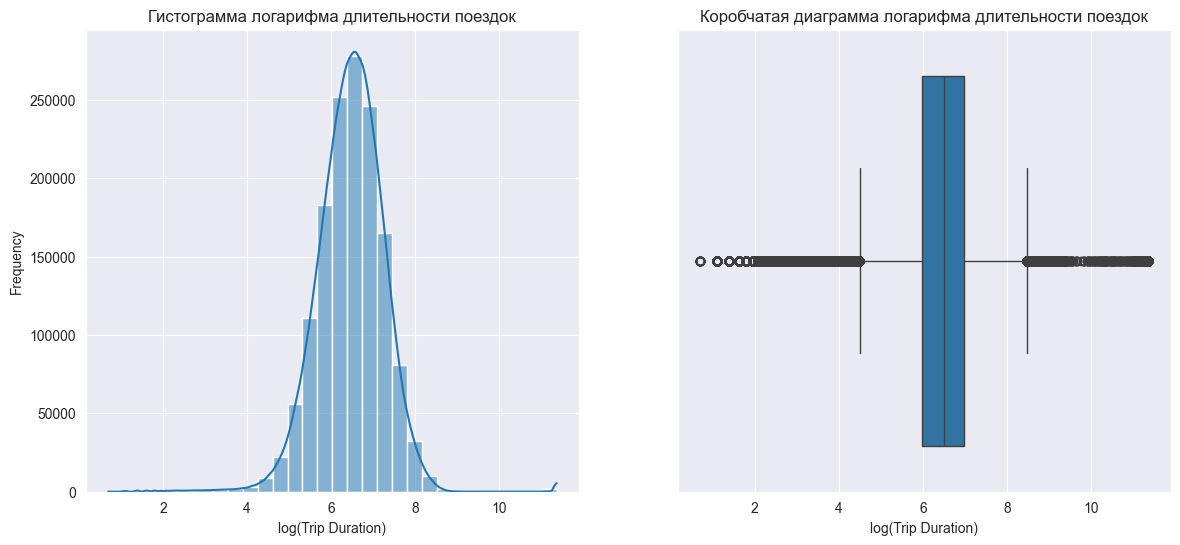

Статистика теста Д'Агостино: 138350.1661
p-значение: 0.0000
Отвергаем нулевую гипотезу: данные не распределены нормально.


In [42]:
# Построим гистограмму
from scipy.stats import normaltest
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(taxi_data['trip_duration_log'], bins=30, kde=True)
plt.title('Гистограмма логарифма длительности поездок')
plt.xlabel('log(Trip Duration)')
plt.ylabel('Frequency')

# Построим коробчатую диаграмму
plt.subplot(1, 2, 2)
sns.boxplot(x=taxi_data['trip_duration_log'])
plt.title('Коробчатая диаграмма логарифма длительности поездок')
plt.xlabel('log(Trip Duration)')

plt.show()

# Проверим нормальность распределения с помощью теста Д’Агостино
stat, p_value = normaltest(taxi_data['trip_duration_log'])

print(f'Статистика теста Д\'Агостино: {stat:.4f}')
print(f'p-значение: {p_value:.4f}')

# Проверка гипотезы
alpha = 0.05
if p_value > alpha:
    print('Невозможно отвергнуть нулевую гипотезу: данные распределены нормально.')
else:
    print('Отвергаем нулевую гипотезу: данные не распределены нормально.')

In [43]:
# Проверим нормальность распределения с помощью теста Д’Агостино-Пирсона
stat, p_value = normaltest(taxi_data['trip_duration_log'])

print(f'Статистика теста Д\'Агостино-Пирсона: {stat:.4f}')
print(f'p-значение: {p_value:.4f}')

# Округлим p-значение до двух знаков после запятой
p_value_rounded = round(p_value, 2)
print(f'p-значение (округленное): {p_value_rounded}')

# Проверка гипотезы
alpha = 0.05
if p_value > alpha:
    print('Невозможно отвергнуть нулевую гипотезу: данные распределены нормально.')
else:
    print('Отвергаем нулевую гипотезу: данные не распределены нормально.')

Статистика теста Д'Агостино-Пирсона: 138350.1661
p-значение: 0.0000
p-значение (округленное): 0.0
Отвергаем нулевую гипотезу: данные не распределены нормально.


p-значение (округленное): **0**.0 \
Отвергаем нулевую гипотезу: данные **не распределены нормально**.

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

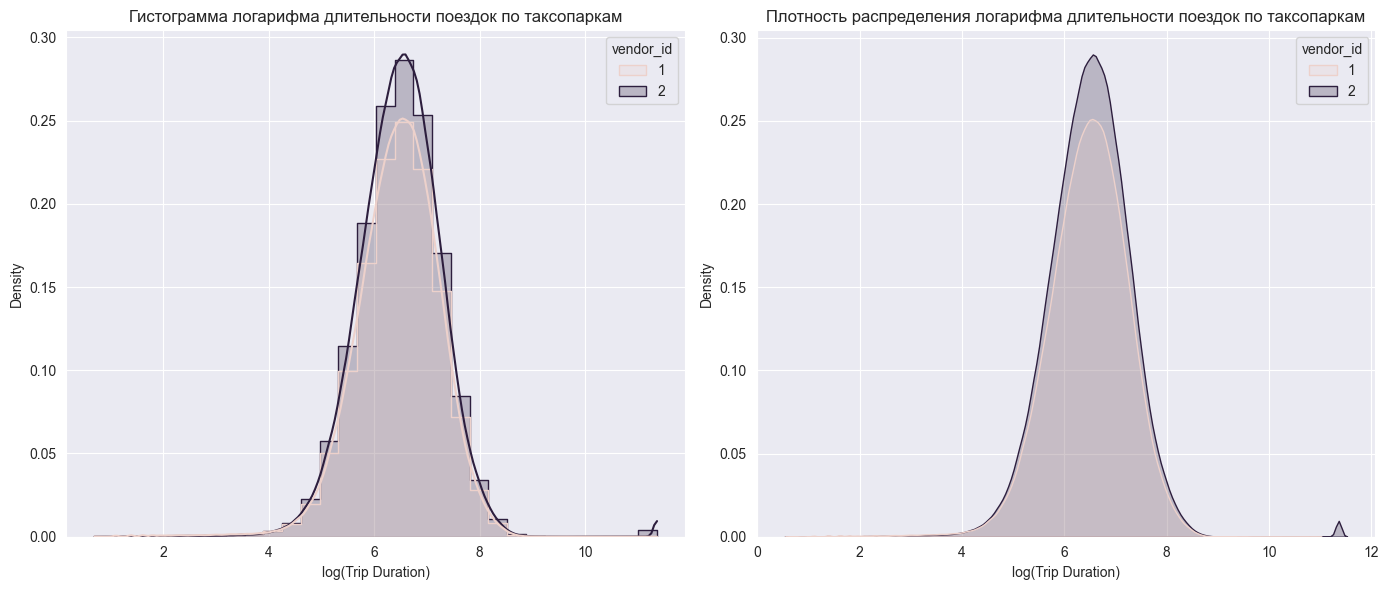

In [44]:
# ваш код здесь
# Построим гистограммы и KDE для каждого таксопарка
plt.figure(figsize=(14, 6))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', bins=30, kde=True, element='step', stat='density')
plt.title('Гистограмма логарифма длительности поездок по таксопаркам')
plt.xlabel('log(Trip Duration)')
plt.ylabel('Density')

# KDE-график
plt.subplot(1, 2, 2)
sns.kdeplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', fill=True)
plt.title('Плотность распределения логарифма длительности поездок по таксопаркам')
plt.xlabel('log(Trip Duration)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Постройте гистограмму и коробчатую диаграмму, которые позволят сравнить распределение длительности поездки в логарифмическом масштабе () в зависимости от таксопарка (vendor_id).

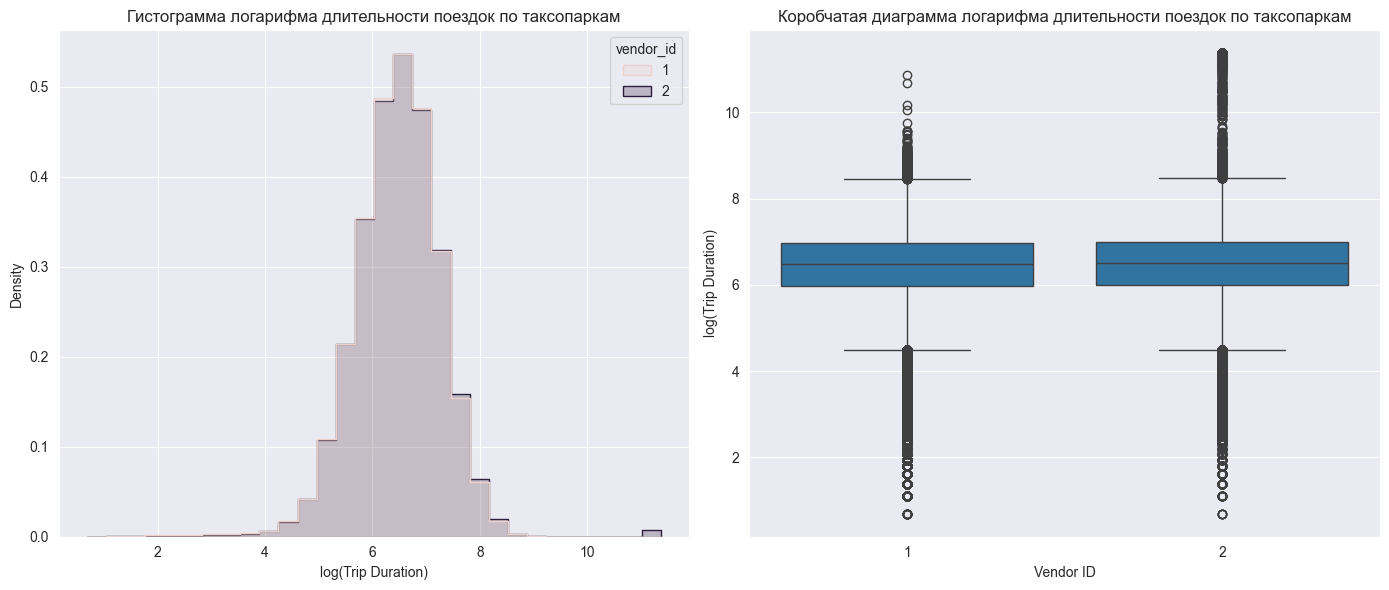

In [45]:
# Построим гистограммы и коробчатые диаграммы для каждого таксопарка
plt.figure(figsize=(14, 6))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', bins=30, element='step', stat='density', common_norm=False)
plt.title('Гистограмма логарифма длительности поездок по таксопаркам')
plt.xlabel('log(Trip Duration)')
plt.ylabel('Density')

# Коробчатая диаграмма
plt.subplot(1, 2, 2)
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log')
plt.title('Коробчатая диаграмма логарифма длительности поездок по таксопаркам')
plt.xlabel('Vendor ID')
plt.ylabel('log(Trip Duration)')

plt.tight_layout()
plt.show()

Из графиков видно что:
**Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.**

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

C:\Users\Anton\AppData\Local\Temp\ipykernel_24176\629586674.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='store_and_fwd_flag')


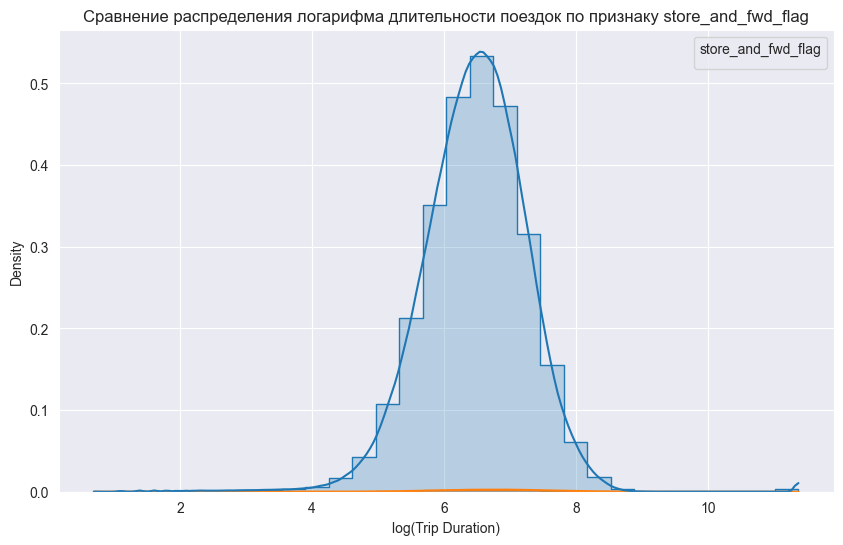

In [48]:
# Построим гистограммы и KDE для каждого значения признака store_and_fwd_flag
plt.figure(figsize=(10, 6))

sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', bins=30, kde=True, element='step', stat='density')
plt.title('Сравнение распределения логарифма длительности поездок по признаку store_and_fwd_flag')
plt.xlabel('log(Trip Duration)')
plt.ylabel('Density')

plt.legend(title='store_and_fwd_flag')
plt.show()

C:\Users\Anton\AppData\Local\Temp\ipykernel_24176\1751501073.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='store_and_fwd_flag')


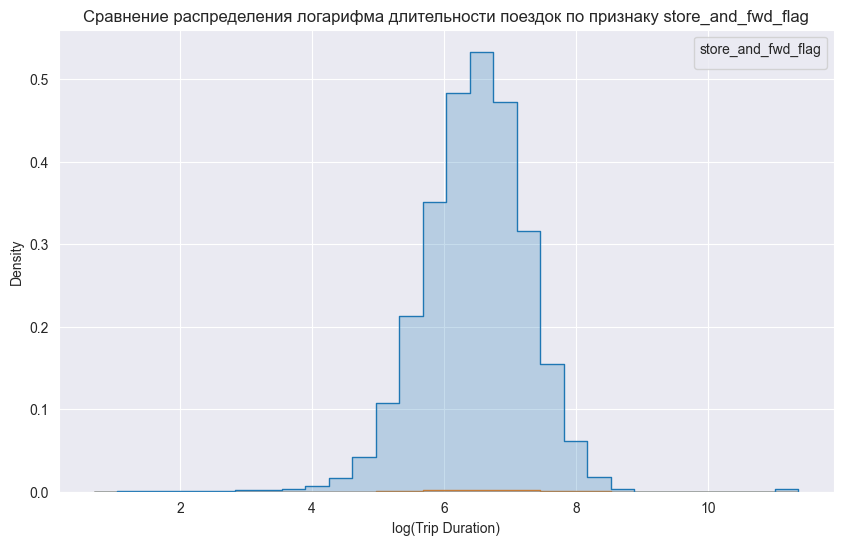

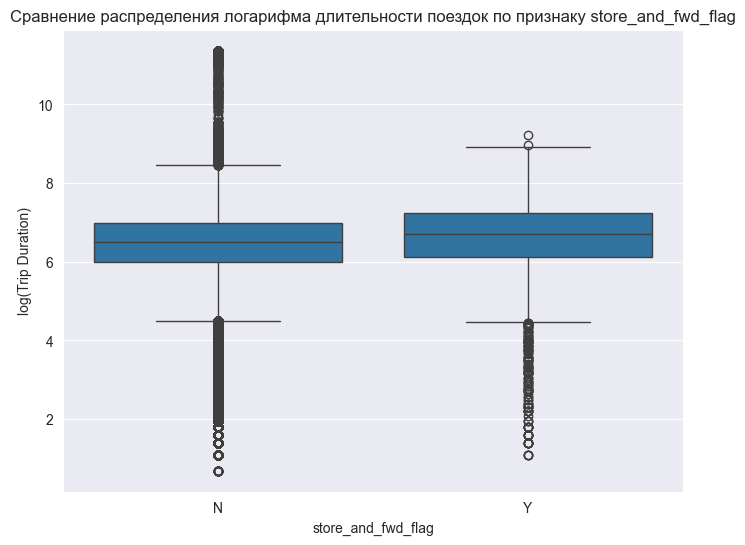

In [49]:
# Построим гистограммы и коробчатые диаграммы для каждого значения признака store_and_fwd_flag
plt.figure(figsize=(10, 6))

# Гистограмма
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', bins=30, element='step', stat='density')
plt.title('Сравнение распределения логарифма длительности поездок по признаку store_and_fwd_flag')
plt.xlabel('log(Trip Duration)')
plt.ylabel('Density')

plt.legend(title='store_and_fwd_flag')
plt.show()

# Коробчатая диаграмма
plt.figure(figsize=(8, 6))
sns.boxplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log')
plt.title('Сравнение распределения логарифма длительности поездок по признаку store_and_fwd_flag')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('log(Trip Duration)')
plt.show()

При анализе распределения видим: \
**Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.**

Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

C:\Users\Anton\AppData\Local\Temp\ipykernel_24176\2554453098.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_hour', data=taxi_data, palette='viridis')


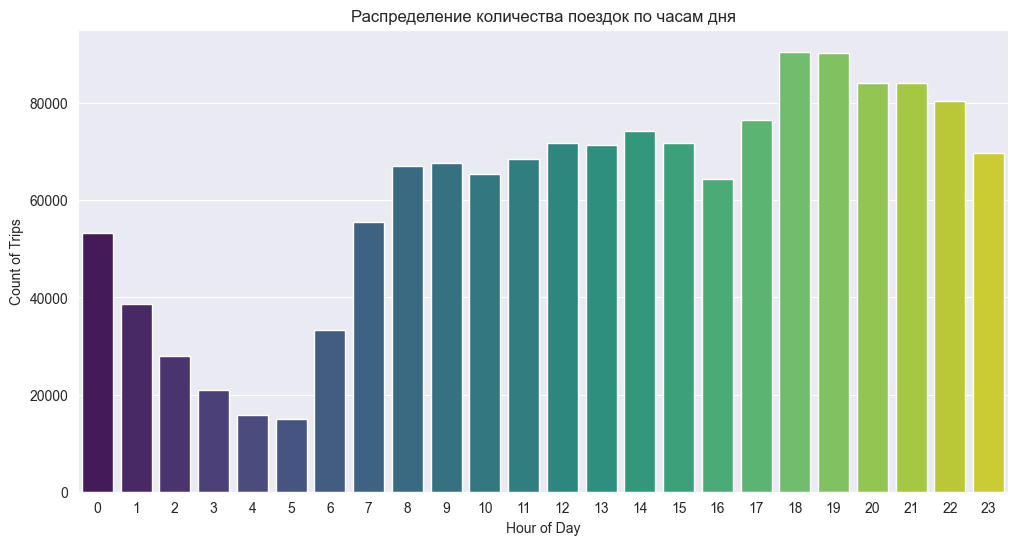

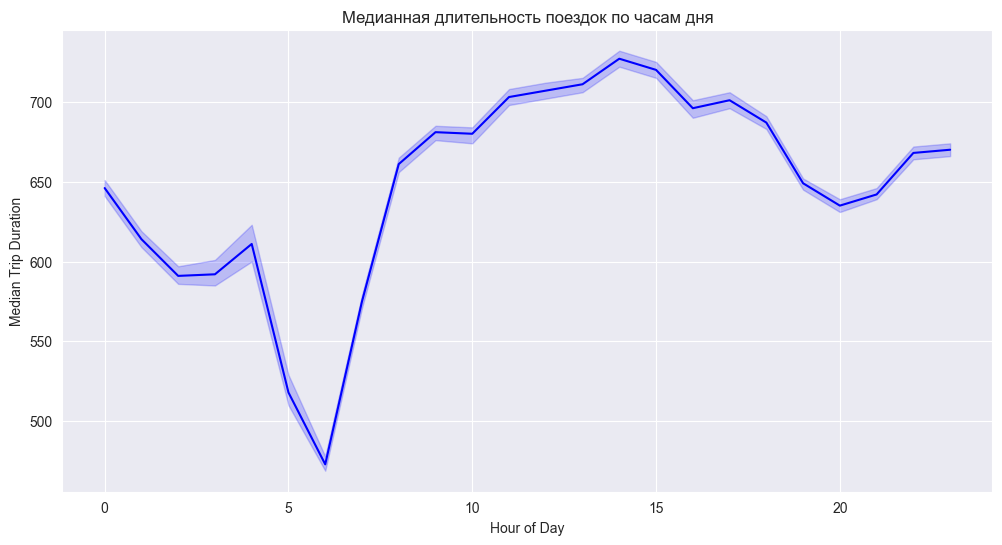

In [50]:
# Распределение количества поездок в зависимости от часа дня
plt.figure(figsize=(12, 6))
sns.countplot(x='pickup_hour', data=taxi_data, palette='viridis')
plt.title('Распределение количества поездок по часам дня')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Trips')
plt.show()

# Зависимость медианной длительности поездки от часа дня
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='trip_duration', data=taxi_data, estimator='median', color='blue')
plt.title('Медианная длительность поездок по часам дня')
plt.xlabel('Hour of Day')
plt.ylabel('Median Trip Duration')
plt.show()

Из графиков видно:\
реже всего такси заказывают **с 00:00 по 5:00**\
пик медианной длительности поездок наблюдается **с 13:00 по 18:00**

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:

а) В какой день недели совершается больше всего поездок?

б) В какой день недели медианная длительность поездок наименьшая?


C:\Users\Anton\AppData\Local\Temp\ipykernel_24176\1943016552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_day_of_week', data=taxi_data, palette='viridis')


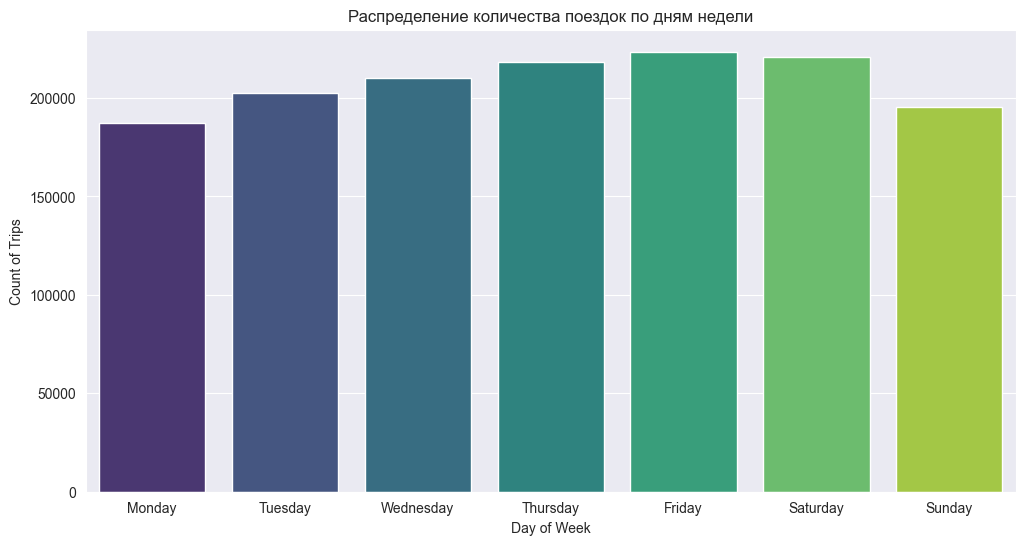

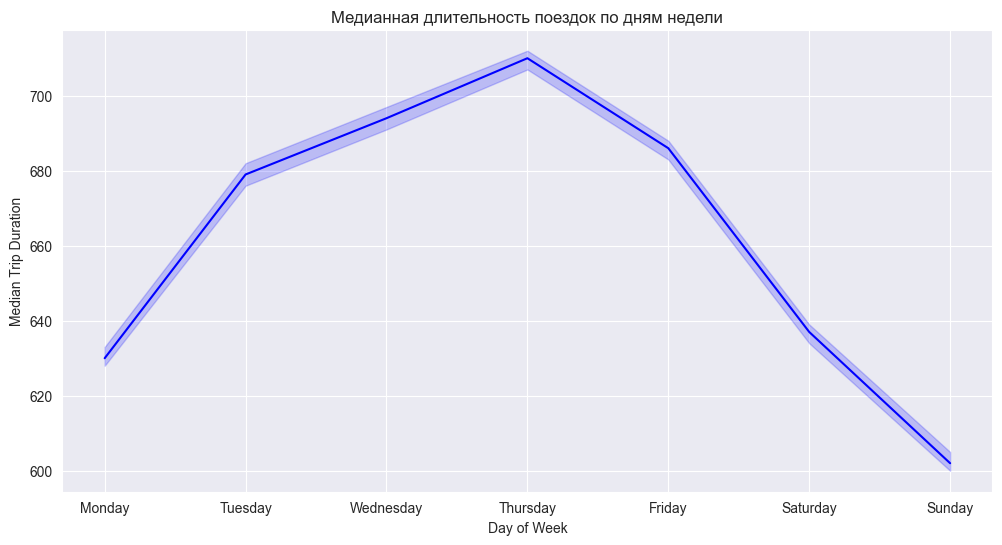

In [51]:
# Распределение количества поездок в зависимости от дня недели
plt.figure(figsize=(12, 6))
sns.countplot(x='pickup_day_of_week', data=taxi_data, palette='viridis')
plt.title('Распределение количества поездок по дням недели')
plt.xlabel('Day of Week')
plt.ylabel('Count of Trips')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

# Зависимость медианной длительности поездки от дня недели
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_day_of_week', y='trip_duration', data=taxi_data, estimator='median', color='blue')
plt.title('Медианная длительность поездок по дням недели')
plt.xlabel('Day of Week')
plt.ylabel('Median Trip Duration')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

Из диаграммы и графика видно:\
а) больше всего поездок совершается в **Пятница (Friday)**\
б) медианная длительность поездок наименьшая в **Воскресенье (Sunday)**

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

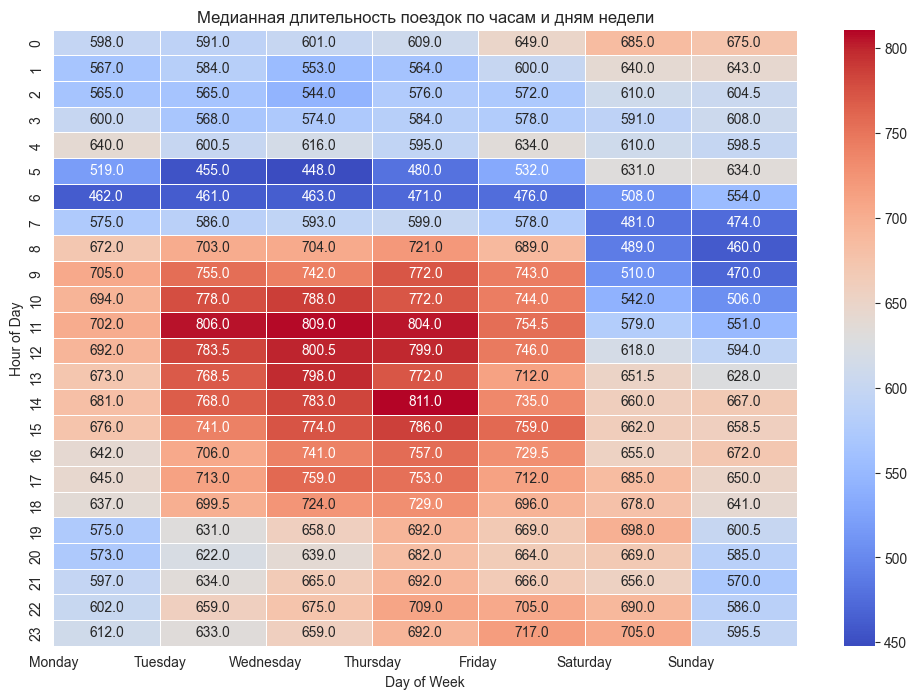

In [52]:
# Создадим сводную таблицу с медианными значениями длительности поездок
pivot_table = taxi_data.pivot_table(values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')

# Визуализируем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5)
plt.title('Медианная длительность поездок по часам и дням недели')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

Из тепловой карты мы видим, что:\
**А Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.**\
**B Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.**

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


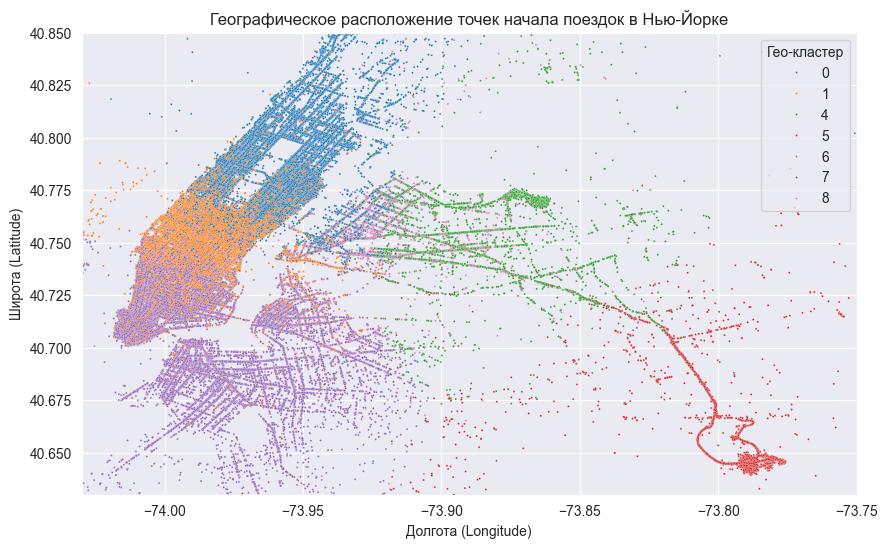

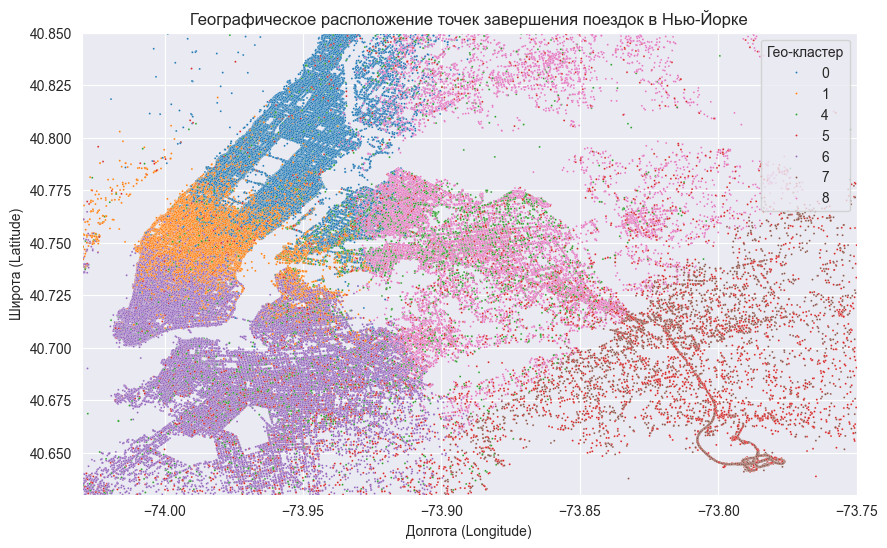

In [53]:
# Ограничения на границы Нью-Йорка
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь

# Фильтрация данных по границам Нью-Йорка
df_nyc = taxi_data[(taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1]) &
            (taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1]) &
            (taxi_data['dropoff_longitude'] >= city_long_border[0]) & (taxi_data['dropoff_longitude'] <= city_long_border[1]) &
            (taxi_data['dropoff_latitude'] >= city_lat_border[0]) & (taxi_data['dropoff_latitude'] <= city_lat_border[1])]

# Создадим диаграмму рассеяния для точек начала поездок
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', data=df_nyc, palette='tab10', s=2)
plt.title('Географическое расположение точек начала поездок в Нью-Йорке')
plt.xlabel('Долгота (Longitude)')
plt.ylabel('Широта (Latitude)')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(title='Гео-кластер', loc='upper right')
plt.grid(True)
plt.show()

# Создадим диаграмму рассеяния для точек завершения поездок
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', data=df_nyc, palette='tab10', s=2)
plt.title('Географическое расположение точек завершения поездок в Нью-Йорке')
plt.xlabel('Долгота (Longitude)')
plt.ylabel('Широта (Latitude)')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(title='Гео-кластер', loc='upper right')
plt.grid(True)
plt.show()

Из диаграмм видно, что в границы Нью-Йорка не попало **2 кластера*

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [54]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [46]:
train_data = taxi_data.copy()

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


а) **id** - уникальный идентификатор поездки, уникален для каждой поездки и не несёт полезной информации.

б) **Утечка данных (data leak)** - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но  эти данные недоступны в реальных условиях.

в) **dropoff_datetime** - дата и время, когда счетчик был отключен. Данный признак будет отсутвовать при прогнозировании длительности поездки (нет смысла прогнозировать, когда мы уже знаем длительность) и позволяет легко получить длительность поездки как разность между временем включения счетчика и временем  отключения.


In [47]:
# г) Исключаем выбранные в пунктах а) и в)
# признаки из исходной таблицы с данными:
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
len(train_data.columns)

25

Получилось **25** столбцов.

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [48]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [49]:
train_data['vendor_id'] = train_data['vendor_id'].map(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)
train_data[['vendor_id', 'store_and_fwd_flag']].mean()

vendor_id            0.535
store_and_fwd_flag   0.006
dtype: float64

а) Среднее значение `vendor_id` = **0.53**

б) Среднее значение `store_and_fwd_flag` = **0.006**

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [50]:
# определяем колонки, которые будем преобразовывать
column_to_coding = ['pickup_day_of_week', 'geo_cluster', 'events']

# определяем энкодер
one_hot_encoder = preprocessing.OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# обучаем
one_hot_encoder.fit(train_data[column_to_coding])

# преобразуе колонки в новый датафрэйм
data_onehot = pd.DataFrame(one_hot_encoder.transform(train_data[column_to_coding]), columns = one_hot_encoder.get_feature_names_out(column_to_coding))
data_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458233 entries, 0 to 1458232
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   pickup_day_of_week_1  1458233 non-null  float64
 1   pickup_day_of_week_2  1458233 non-null  float64
 2   pickup_day_of_week_3  1458233 non-null  float64
 3   pickup_day_of_week_4  1458233 non-null  float64
 4   pickup_day_of_week_5  1458233 non-null  float64
 5   pickup_day_of_week_6  1458233 non-null  float64
 6   geo_cluster_1         1458233 non-null  float64
 7   geo_cluster_2         1458233 non-null  float64
 8   geo_cluster_3         1458233 non-null  float64
 9   geo_cluster_4         1458233 non-null  float64
 10  geo_cluster_5         1458233 non-null  float64
 11  geo_cluster_6         1458233 non-null  float64
 12  geo_cluster_7         1458233 non-null  float64
 13  geo_cluster_8         1458233 non-null  float64
 14  geo_cluster_9         1458233 non-

Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?
**18**

Добавим полученную таблицу с закодированными признаками:

In [51]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(column_to_coding, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [52]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [53]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)
# OOT = out of time

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [54]:
# определяем объект реализующий KBest
skb = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
# обучаем функцию на тренировочных данных и сразу преобразуем их
X_train = pd.DataFrame(skb.fit_transform(X_train,y_train_log),columns = skb.get_feature_names_out())
X_train.info()
# преобразуем проверочные данные
X_valid = pd.DataFrame(skb.transform(X_valid),columns = skb.get_feature_names_out())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977016 entries, 0 to 977015
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vendor_id             977016 non-null  float64
 1   passenger_count       977016 non-null  float64
 2   pickup_longitude      977016 non-null  float64
 3   pickup_latitude       977016 non-null  float64
 4   dropoff_longitude     977016 non-null  float64
 5   dropoff_latitude      977016 non-null  float64
 6   store_and_fwd_flag    977016 non-null  float64
 7   pickup_hour           977016 non-null  float64
 8   pickup_holiday        977016 non-null  float64
 9   total_distance        977016 non-null  float64
 10  total_travel_time     977016 non-null  float64
 11  number_of_steps       977016 non-null  float64
 12  haversine_distance    977016 non-null  float64
 13  temperature           977016 non-null  float64
 14  pickup_day_of_week_1  977016 non-null  float64
 15  

В список отобранных вошли:

A) `vendor_id `

B) `passenger_count`

C) `number_of_steps`

D) `temperature`


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [55]:
# определяем объект реализующий mim-max преобразование
min_max_scaler = preprocessing.MinMaxScaler()
# обучаем функцию на тренировочных данных и сразу преобразуем их
X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train),
                       columns = min_max_scaler.get_feature_names_out())
# преобразуем проверочные данные
X_valid = pd.DataFrame(min_max_scaler.transform(X_valid),
                              columns = min_max_scaler.get_feature_names_out())
X_valid.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_4,geo_cluster_5,geo_cluster_7,geo_cluster_8
count,"481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000",...,"481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000","481,217.000"
mean,0.535,0.238,0.791,0.638,0.791,0.731,0.005,0.592,0.035,0.053,...,0.144,0.150,0.153,0.152,0.134,0.405,0.028,0.023,0.010,0.031
std,0.499,0.188,0.001,0.003,0.001,0.003,0.074,0.278,0.184,0.060,...,0.351,0.357,0.360,0.359,0.340,0.491,0.164,0.149,0.102,0.174
min,0.000,0.000,-0.000,0.095,-0.000,0.255,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.143,0.791,0.637,0.791,0.729,0.000,0.391,0.000,0.019,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.143,0.791,0.639,0.791,0.731,0.000,0.609,0.000,0.031,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.286,0.792,0.640,0.792,0.732,0.000,0.826,0.000,0.058,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
max,1.000,1.286,0.925,0.877,0.925,1.001,1.000,1.000,1.000,1.071,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Cреднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки = **0.54**

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [65]:
# ваш код здесь

### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [66]:
# ваш код здесь

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [67]:
# ваш код здесь

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [68]:
# ваш код здесь

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [69]:
# ваш код здесь
GridSearchCV
optuna / hyperopt

NameError: name 'GridSearchCV' is not defined

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [1]:
# ваш код здесь
from sklearn.ensemble import RandomForestRegressor

In [78]:
model_RF = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True,
    n_jobs=-1,
)

In [87]:
model_RF.fit(X_train, y_train_log)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.5min finished


RandomForestRegressor(max_depth=12, min_samples_split=20, n_estimators=200,
                      n_jobs=-1, random_state=42, verbose=True)

In [88]:
y_train_pred_RF = model_RF.predict(X_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    2.9s finished


In [89]:
y_valid_pred_RF = model_RF.predict(X_valid)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.3s finished


In [2]:
from sklearn.metrics import root_mean_squared_error


In [90]:
rmse_rf_train = root_mean_squared_error(y_train_log, y_train_pred_RF)
rmse_rf_train

0.3990760322881213

In [92]:
rmse_rf_valid = root_mean_squared_error(y_valid_log, y_valid_pred_RF)
rmse_rf_valid

0.41407756155766834

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [56]:
# ваш код здесь
from sklearn.ensemble import GradientBoostingRegressor

In [60]:
model_GB = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=1,
    
)

In [61]:
model_GB.fit(X_train, y_train_log)

      Iter       Train Loss   Remaining Time 
         1           0.3110           10.14m
         2           0.2247            9.42m
         3           0.1985            9.08m
         4           0.1873            8.87m
         5           0.1818            8.72m
         6           0.1783            8.58m
         7           0.1749            8.47m
         8           0.1718            8.37m
         9           0.1705            8.26m
        10           0.1693            8.14m
        20           0.1595            7.17m
        30           0.1540            6.29m
        40           0.1505            5.33m
        50           0.1475            4.41m
        60           0.1457            3.50m
        70           0.1433            2.61m
        80           0.1409            1.74m
        90           0.1393           51.93s
       100           0.1380            0.00s


GradientBoostingRegressor(learning_rate=0.5, max_depth=6, min_samples_split=30,
                          random_state=42, verbose=1)

In [62]:
y_train_pred_GB = model_GB.predict(X_train)
y_valid_pred_GB = model_GB.predict(X_valid)

In [70]:
rmse_gb_train = root_mean_squared_error(y_train_log, y_train_pred_GB)
print(f'ошибка на тренировочной {rmse_gb_train:.2f}')
rmse_gb_valid = root_mean_squared_error(y_valid_log, y_valid_pred_GB)
print(f'ошибка на валидационной {rmse_gb_valid:.2f}')

ошибка на тренировочной 0.37
ошибка на валидационной 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


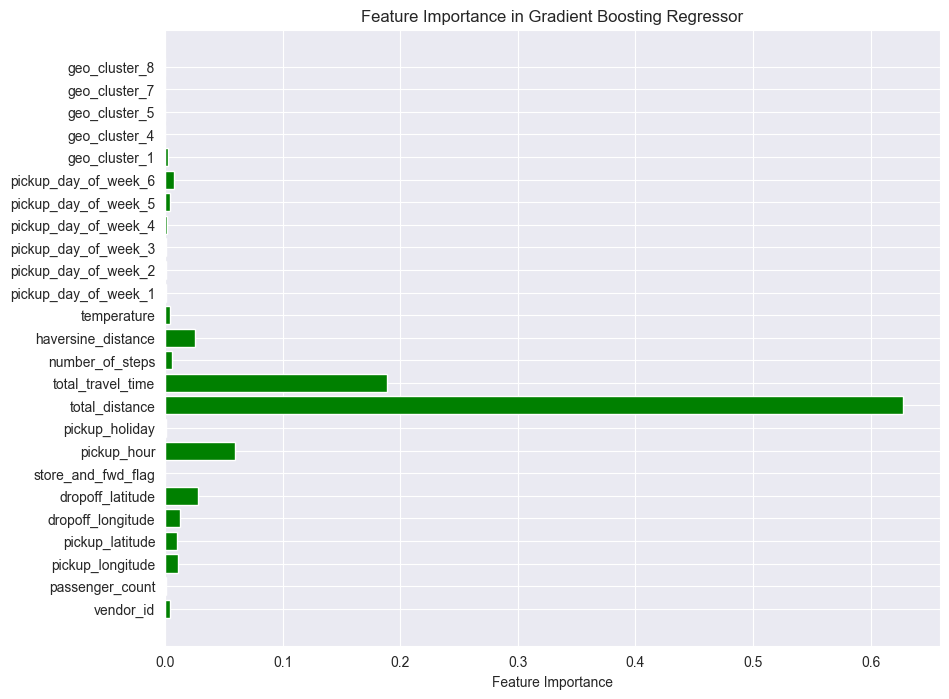

In [71]:
# ваш код здесь
# Получаем массив значимостей коэффициентов признаков
feature_importances = model_GB.feature_importances_

# Получаем массив имен признаков
feature_names = X_train.columns

# Создаем столбчатую диаграмму
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_names)), feature_importances, color='g')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting Regressor')
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# ваш код здесь

In [72]:
y_valid_pred_GB

452652    5.966
585387    5.220
1226235   2.197
145996    6.312
120104    6.006
           ... 
346404    5.900
40569     7.178
1295514   6.363
877794    7.008
1108352   6.500
Name: trip_duration_log, Length: 481217, dtype: float64

In [74]:
y_valid_pred_GB = pd.DataFrame(y_valid_pred_GB, columns=['trip_duration_log_pred_gb'])

In [80]:
y_valid_log_df = pd.DataFrame(y_valid_log, columns=['trip_duration_log'])

In [83]:
y_valig_log_to_normal = np.exp(y_valid_log_df['trip_duration_log'])-1


In [85]:
y_valid_pred_GB_normal = np.exp(y_valid_pred_GB['trip_duration_log_pred_gb'])-1

In [86]:
from sklearn.metrics import median_absolute_error as MAE

In [90]:
MAE_valid_gb = MAE(y_valig_log_to_normal, y_valid_pred_GB_normal)
print(f'Метрика МАЕ в минутах {MAE_valid_gb/60: .1f}')

Метрика МАЕ в минутах  1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

In [91]:
gdown.download(id='10aaa5fS9HNKH97WL_s6_37DlfUgeDyUT', output='data/test.csv') # Скачаем датасет праздников и поместим по адресу 'data/test.csv'

Downloading...
From: https://drive.google.com/uc?id=10aaa5fS9HNKH97WL_s6_37DlfUgeDyUT
To: F:\Games\JetBrains\Projects\Project_2\для себя\data\test.csv
100%|██████████| 70.8M/70.8M [01:13<00:00, 957kB/s] 


'data/test.csv'

In [92]:
gdown.download(id='1w-rwdZHaiQgAbjOSLFbHCSBslw35O3NL', output='data/osrm_data_test.csv') # Скачаем датасет праздников и поместим по адресу 'data/osrm_data_test.csv'

Downloading...
From (original): https://drive.google.com/uc?id=1w-rwdZHaiQgAbjOSLFbHCSBslw35O3NL
From (redirected): https://drive.google.com/uc?id=1w-rwdZHaiQgAbjOSLFbHCSBslw35O3NL&confirm=t&uuid=ad38a344-bc86-4a72-9a88-e0260858446b
To: F:\Games\JetBrains\Projects\Project_2\для себя\data\osrm_data_test.csv
100%|██████████| 315M/315M [04:00<00:00, 1.31MB/s] 


'data/osrm_data_test.csv'

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [114]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [115]:
def add_datetime_features(target: pd.DataFrame):
    df = target.copy()
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday
    return df

In [116]:
def add_holiday_features(target: pd.DataFrame, holiday: pd.DataFrame):
    df = target.copy()
    df_holiday = holiday.copy()
    
    df['pickup_date'] = pd.to_datetime(df['pickup_date'], format='%Y-%m-%d')
    df_holiday['date'] = pd.to_datetime(df_holiday['date'], format='%Y-%m-%d') 
    
    df = df.merge(df_holiday['date'],how='left', left_on='pickup_date', right_on='date' )
    df['pickup_holiday'] = df['date'].apply(lambda x: 0 if pd.isnull(x) else 1)
    
    df.drop('date', axis=1, inplace=True)
    
    return df

In [117]:
def add_osrm_features(target: pd.DataFrame, osrm: pd.DataFrame):
    df = target.copy()
    df = df.merge(osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], how='left', left_on='id', right_on='id')
    
    return df

In [118]:
"""
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))
"""

"\ntest_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')\ntest_data = add_datetime_features(test_data)\ntest_data = add_holiday_features(test_data, holiday_data)\ntest_data = add_osrm_features(test_data, osrm_data_test)\ntest_data = add_geographical_features(test_data)\ntest_data = add_cluster_features(test_data, kmeans)\ntest_data = add_weather_features(test_data, weather_data)\ntest_data = fill_null_weather_data(test_data)\n\ntest_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)\ntest_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)\ntest_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()\ncolumn_names = one_hot_encoder.get_feature_names_out(columns_to_change)\ntest_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)\n\ntest_data = pd.concat(\n    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1)

In [119]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')

In [120]:
test_data = add_datetime_features(test_data)

In [121]:
test_data = add_holiday_features(test_data, holiday_data)

In [122]:
test_data = add_osrm_features(test_data, osrm_data_test)

In [123]:
test_data = add_geographical_features(test_data)

In [124]:
test_data = add_cluster_features(test_data, kmeans)

In [125]:
test_data = add_weather_features(test_data, needle_weather_data)

In [126]:
test_data = fill_null_weather_data(test_data)

In [127]:
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

In [129]:
test_data_onehot = one_hot_encoder.fit_transform(test_data[column_to_coding])
column_names = one_hot_encoder.get_feature_names_out(column_to_coding)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

In [131]:
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(column_to_coding, axis=1), test_data_onehot],
    axis=1
)

In [133]:
best_features = skb.get_feature_names_out()

In [134]:
X_test = test_data[best_features]

In [135]:
X_test_scaled = min_max_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [164]:
X_test_scaled_1 = pd.DataFrame(X_test_scaled,  columns = min_max_scaler.get_feature_names_out())
X_test_scaled_1

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_4,geo_cluster_5,geo_cluster_7,geo_cluster_8
0,0.000,0.143,0.791,0.636,0.791,0.731,0.000,1.000,0.000,0.043,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1,0.000,0.143,0.792,0.631,0.792,0.722,0.000,1.000,0.000,0.033,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.143,0.791,0.637,0.791,0.729,0.000,1.000,0.000,0.017,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1.000,0.143,0.792,0.640,0.791,0.729,0.000,1.000,0.000,0.080,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
4,0.000,0.143,0.791,0.639,0.792,0.731,0.000,1.000,0.000,0.013,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,0.000,0.143,0.791,0.636,0.791,0.729,0.000,0.000,1.000,0.013,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
625130,0.000,0.143,0.791,0.638,0.792,0.733,0.000,0.000,1.000,0.109,...,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
625131,0.000,0.286,0.791,0.639,0.793,0.730,0.000,0.000,1.000,0.108,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
625132,0.000,0.143,0.791,0.637,0.793,0.743,0.000,0.000,1.000,0.270,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [136]:
y_test_predict = model_GB.predict(X_test_scaled)

F:\Games\JetBrains\Projects\Project_2\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [138]:
y_test_predict = pd.DataFrame(y_test_predict, columns=['trip_duration_log_pred_gb'])
y_test_predict_normal = np.exp(y_test_predict['trip_duration_log_pred_gb'])-1

In [139]:
y_test_predict_normal

0          812.071
1          466.921
2          344.594
3          956.078
4          273.790
            ...   
625129     352.842
625130   1,485.505
625131   1,976.598
625132   2,030.694
625133   1,215.507
Name: trip_duration_log_pred_gb, Length: 625134, dtype: float64

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [140]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict_normal})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [141]:
#!pip install xgboost catboost

После чего модуль можно импортировать:

In [143]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [165]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log)
dtest = xgb.DMatrix(X_test_scaled_1)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [166]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74193
[10]	train-rmse:0.49088	valid-rmse:0.49348
[20]	train-rmse:0.44044	valid-rmse:0.44330
[30]	train-rmse:0.42617	valid-rmse:0.42916
[40]	train-rmse:0.41819	valid-rmse:0.42137
[50]	train-rmse:0.41244	valid-rmse:0.41596
[60]	train-rmse:0.40896	valid-rmse:0.41286
[70]	train-rmse:0.40616	valid-rmse:0.41034
[80]	train-rmse:0.40337	valid-rmse:0.40784
[90]	train-rmse:0.40131	valid-rmse:0.40613
[100]	train-rmse:0.39957	valid-rmse:0.40474
[110]	train-rmse:0.39810	valid-rmse:0.40348
[120]	train-rmse:0.39658	valid-rmse:0.40223
[130]	train-rmse:0.39522	valid-rmse:0.40118
[140]	train-rmse:0.39453	valid-rmse:0.40075
[150]	train-rmse:0.39374	valid-rmse:0.40021
[160]	train-rmse:0.39248	valid-rmse:0.39923
[170]	train-rmse:0.39159	valid-rmse:0.39859
[180]	train-rmse:0.39081	valid-rmse:0.39809
[190]	train-rmse:0.39009	valid-rmse:0.39770
[200]	train-rmse:0.38936	valid-rmse:0.39730
[210]	train-rmse:0.38872	valid-rmse:0.39690
[220]	train-rmse:0.38809	valid-rmse:0.39651

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [167]:
#Делаем предсказание на тестовом наборе данных
y_test_predict_xgb = np.exp(model_xgb.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.39415


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

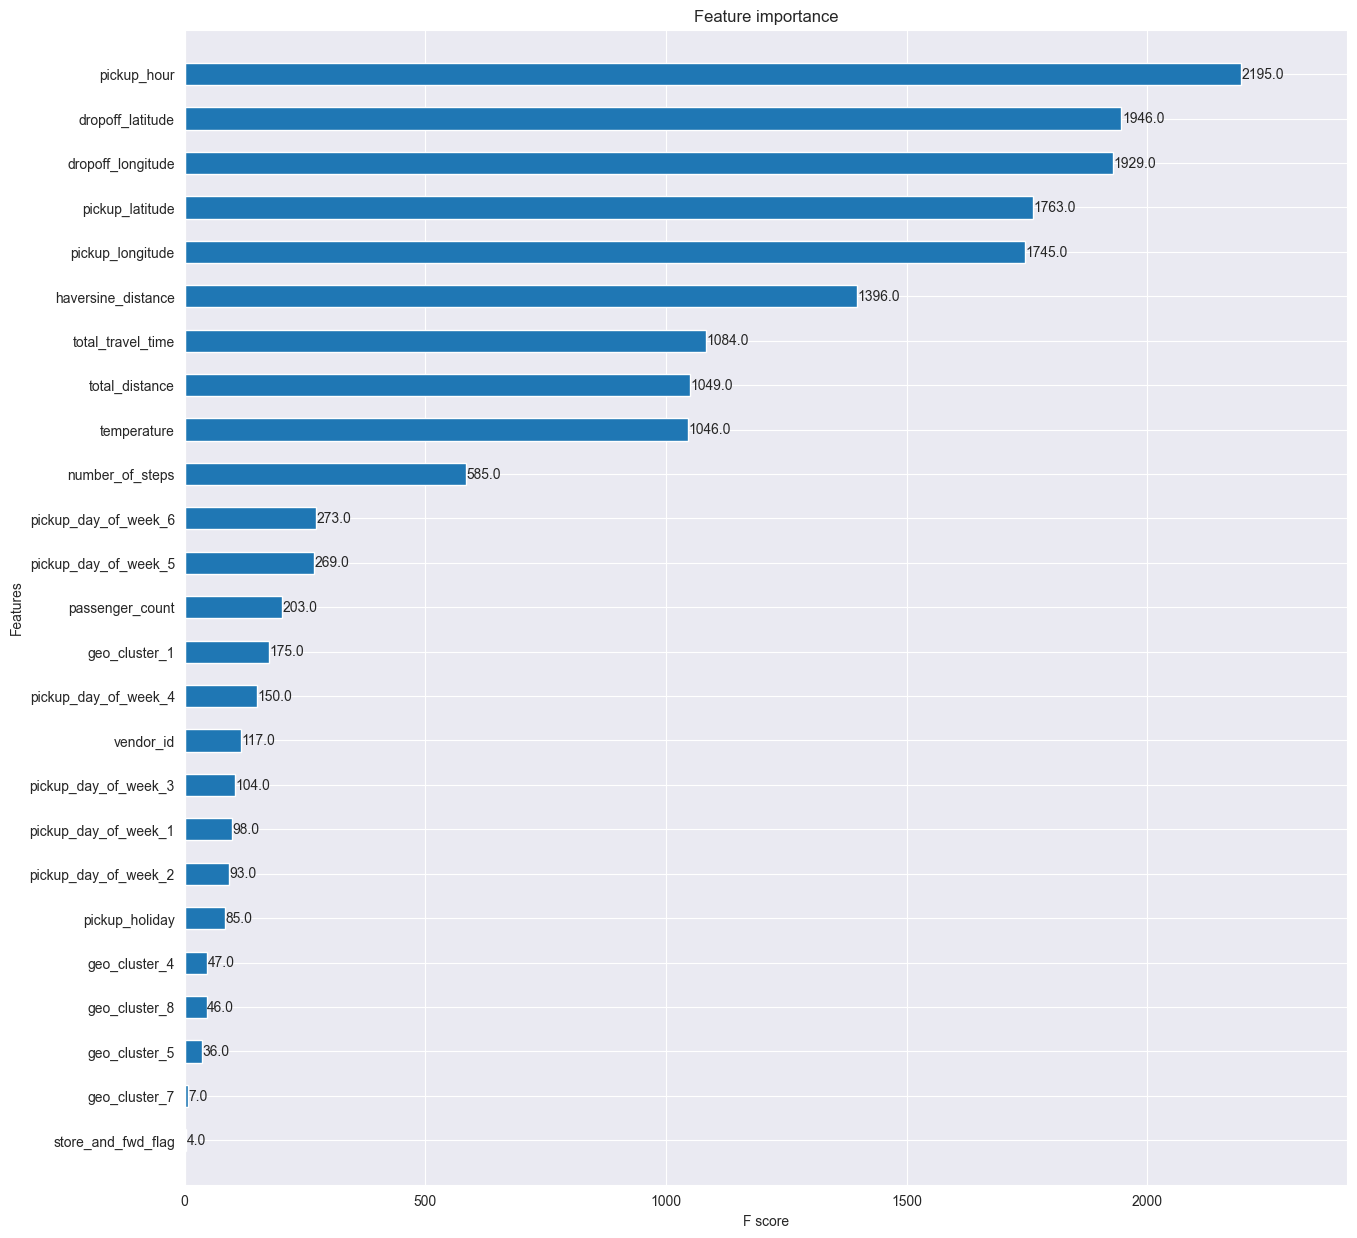

In [168]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)